# Regression problems
This tutorial is a base tutorial to teach regression methods with tensorflow. It can be found on https://www.tensorflow.org/tutorials/keras/regression. The goal of the tutorial is to do a regression on fuel consumption from the Auto MPG dataset.

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Additional libraries I will use
from random import seed
from random import randint
from random import sample
seed(1)

# Make Numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)


After having loadad all what needed, we proceed to downloading the Auto MPG dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). We additionally drop NAs to clean the dataset and make the tutorial easier. Additionally, we one-hot encode the values in the column 'Origins' with pd.get_dummies (basically transforming the column in 3 columns coded as 0 or 1):


In [127]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()

dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Time to split the dataset in training and test! Note: the argument 'frac' in pd.sample() assigns a percentage of the content to be sampled (e.g., 80%). The argument 'random_state' is just a seed.

In [128]:
training_amount = 0.8
train_dataset = dataset.sample(frac=training_amount, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Data inspection
We use the package Seaborn to inspect the data by plotting the data and then see overall stats.

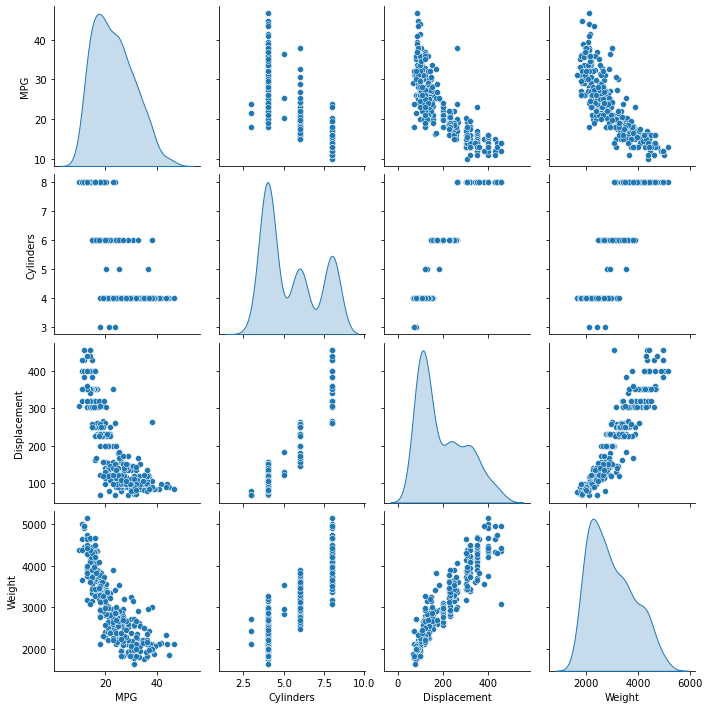

In [129]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [130]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


The next step consists in separating features from labels. Labels are the value that we want to predict, in this case miles-per-gallon, 'MPG'.

In [131]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization
The features have very different ranges. One then needs to normalize the features to make the modelling easier. This is because features are multiplied by weigths. Models might converge without feature normalization, but training becomes more stable through it and it is good practice. There is a layer for this. Then, the function 'adapt()' sets the state of a preprocessing layer based on the input training data. The reason is that normalizer only determines the model but has nothing to do with the input, it's a separate process. That is why both Normalization and .adapt() need to be called.

Only after the model is called, it gives back the input data normalized independently.

In [132]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
#print(normalizer.mean.numpy())

Now we call the model on random input data:

In [133]:
chosen = randint(0, train_features.shape[0])
random_input = np.array(train_features.iloc[chosen])

with np.printoptions(precision=2, suppress=True):
    print('Example:', random_input)
    print()
    print('Normalized:', normalizer(random_input).numpy())

Example: [   4.   110.    87.  2672.    17.5   70.     1.     0.     0. ]

Normalized: [[-0.87 -0.82 -0.47 -0.38  0.7  -1.61  2.15 -0.5  -1.29]]


## Linear regression
Let us start from a regression with one variable only, the model being 'Horsepower' ~ 'MPG'. To do this, after the normalization layer we will apply a Dense layer with one output.

In [134]:
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

# build model
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_21 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Now the model is ready but not trained. Let's apply it as is on 10 random values for "Horsepower".

In [135]:
random_numbers = sample(range(horsepower.shape[0]), 10)
#horsepower[[1,3],]
horsepower_model.predict(horsepower[random_numbers,])

1/1 [==============================] - 0s 66ms/step


array([[ 0.338],
       [-1.201],
       [-0.826],
       [-0.411],
       [ 2.709],
       [-0.618],
       [-0.91 ],
       [-0.702],
       [ 1.253],
       [ 1.669]], dtype=float32)

To train the model, we need to use Model.compile. We need to compile 'loss' and 'optimizer', as these will allow to define what will be optimized (in this case, the mean absolute error). We use the Adam algorithm for optimizing. We then train for 100 epochs.

In [136]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)


In [137]:

%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # calculate validation results on 20% of training data
    validation_split = 0.2)

CPU times: total: 6.44 s
Wall time: 5.58 s


Let's visualize what we have been doing here and save the results of the one-variable model for later.

In [138]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803419,4.189555,95
96,3.807206,4.163456,96
97,3.805048,4.182140,97
98,3.804392,4.178199,98
99,3.803191,4.202166,99


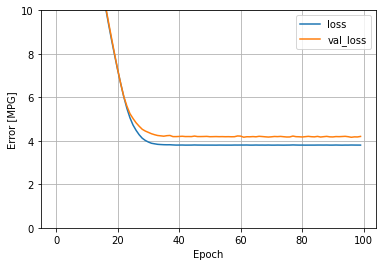

In [139]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

8/8 [==============================] - 0s 3ms/step


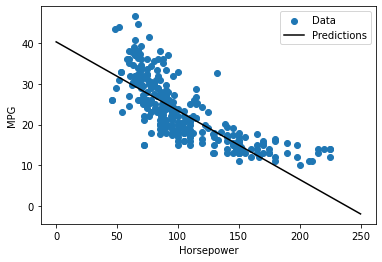

In [140]:
onevar_results = {}
onevar_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

plot_horsepower(x,y)

## Multiple linear regression
The configuration is almost the same here, but it uses the normalizer that we defined beforehand (with all values).

In [141]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# THis creates predictions that have one dimension (the dimension of the batch is 10 now)
linear_model.predict(train_features.iloc[random_numbers])

1/1 [==============================] - 0s 67ms/step


array([[-1.444],
       [-0.741],
       [ 1.173],
       [ 1.061],
       [-0.56 ],
       [ 1.292],
       [-1.337],
       [ 0.862],
       [-0.47 ],
       [-0.715]], dtype=float32)

Let's check that weights created in the kernel are 9, one per feature.

In [142]:
linear_model.layers[1].kernel

<tf.Variable 'dense_22/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.106],
       [ 0.09 ],
       [ 0.116],
       [-0.116],
       [ 0.593],
       [-0.583],
       [-0.446],
       [ 0.744],
       [ 0.434]], dtype=float32)>

Time to configurate and train the model like before.

In [143]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [144]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

CPU times: total: 6.47 s
Wall time: 5.69 s


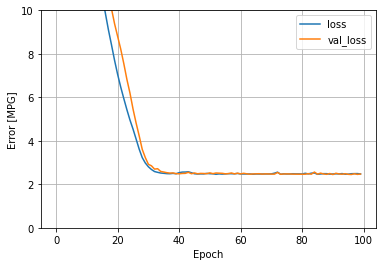

In [145]:
plot_loss(history)

Time to collect results for after.

In [146]:
onevar_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

## Deep neural networks
Let's apply a DNN approach here. The code is basically the same, but it includes several non-linear levels that are hidden (i.e. in between input and output). Here we will have the following layers:
1. normalization (in pre-processing)
2. dense 1, with ReLU activation
3. dense 2, with ReLU activation
4. a linear Dense layer with single output

We define a function to train the model so that we can test both a single input and multiple inputs.

In [147]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

Let's create a DNN model with 'Horsepower' as explanatory variable. It will use horsepower_normalizer with was defined before. This model will have more than 4000 trainable parameters (compared to the regression)

In [148]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_23 (Dense)            (None, 64)                128       
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Let's train our model!

CPU times: total: 7.12 s
Wall time: 5.77 s


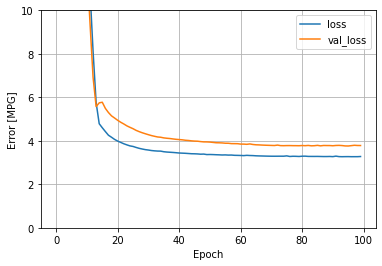

In [149]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

plot_loss(history)

This seems to be slightly better than the simple linear regression. But I'm not sure it's worth it the "black box" approach in the DNN. Does it fit better the data though?

8/8 [==============================] - 0s 1ms/step


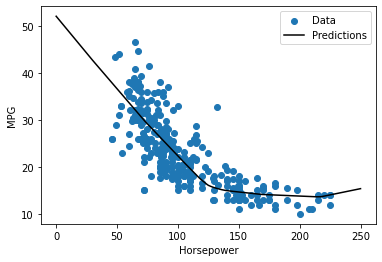

In [150]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x, y)

Wow. The model made full use of the non-linearities of the layers. So yes, while the error function isn't better, the model is definitely much better. Let's save the results.

In [151]:
onevar_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'], 
                                                                       test_labels, verbose=0)

## Regression with DNN and multiple inputs
Same as before, but with all the features.

In [152]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_12 (Normaliza  (None, 9)                19        
 tion)                                                           
                                                                 
 dense_26 (Dense)            (None, 64)                640       
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [153]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
) 

CPU times: total: 7.36 s
Wall time: 5.64 s


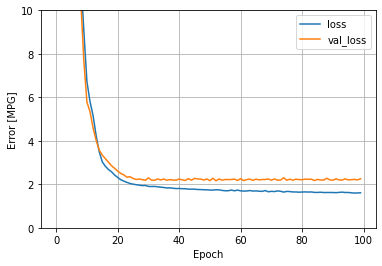

In [154]:
plot_loss(history)

In [155]:
onevar_results['dnn_model'] = dnn_model.evaluate(test_features, 
                                                 test_labels,
                                                 verbose=0)

## Comparing models and make predictions
We ran 4 models, two linear regressions and two DNN models, with different amounts of inputs used. How did they do?

In [156]:
pd.DataFrame(onevar_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.643559
linear_model,2.483639
dnn_horsepower_model,2.898741
dnn_model,1.650547


The full DNN model beat the others by far. The full linear regression is better than the single DNN regression, however not by much. That is a tremendously interesting result in my opinion, as it might make predictions of complex variables easier even from only collecting few variables. Let's do some predictions using the test dataset now.

3/3 [==============================] - 0s 3ms/step


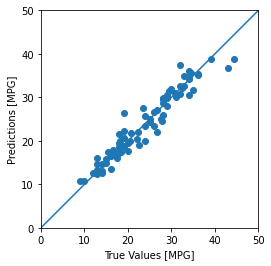

In [157]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

The model does some quite good predictions. Let us check errors.

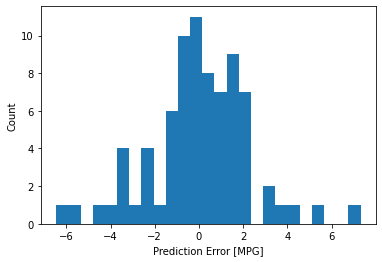

In [158]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Let's say we are satisfied with the model. Then, we can save it for further use!

In [159]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


## Addenda
- Classic loss functions are tf.losses.MeanSquaredError and tf.losses.MeanAbsoluteError. The mean absolute error is obviously less sensitive to outliers. For classification problems, other kinds of loss functions can be used.
- Normalization is especially important when input data have very different intervals.
- Always pay attention to overfitting. While it was not an issue in this tutorial, a proper analysis of results is always very important.